# Figure 7: Optimal network size for highest Turing robustness

## Introduction
In this notebook, we analyse the variation in propotion of Turing I instabilities with respect to network size *N* and variance $σ^2$. <br> <br>

### Note
In the final MSc project:

- the network size *N* ranges from 3 to 100.

- the variance $σ^2$ ranges from 0 to 1 with 0.02 increment.

These parameters can be edited below as needed. <br> <br>
***

## Code

### 1. Import Libraries

In [34]:
import pandas as pd
import numpy as np
import os
from scipy.signal import argrelextrema
import time
from multiprocessing.pool import ThreadPool
import matplotlib.pyplot as plt
import seaborn as sns

### 2. Define Functions

First, we define the random matrix generating function *gen_matrix_F()* with parameters *n* (network size) and *vr* (variance).

In [17]:
def gen_matrix_F(n,vr):
    x, y = n, vr
    I = np.eye(n)
    mu = 0
    B = mu + np.sqrt(vr) * np.random.randn(n, n)
    np.fill_diagonal(B, 0)
    A = -I + B
    D = np.zeros((n, n))
    return A, D

The commented part can be used when the sparsity > 0. It's simply a modified varsion of the *gen_matrix_F* function that injects sparsity. 

In [35]:
# code for sparsity > 0, dictionary = {network size:n of 0 entries}
# def gen_matrix_F(n, vr):
    #sparsity_dict = {3: , 4: , 5: , 6: , 7: , 8: , 9: , 10: }
    #I = np.eye(n)
    #mu = 0
    #B = mu + np.sqrt(vr) * np.random.randn(n, n)
    #np.fill_diagonal(B, 0)
    #A = -I + B
    #mask = np.eye(n) == 0
    #od = np.sum(mask)
    #s = sparsity_dict[n]
    #odi = np.where(mask)
    #indices_to_zero = np.random.choice(od, s, replace=False)
    #for index in indices_to_zero:
        #i, j = odi[0][index], odi[1][index]
        #A[i, j] = 0
    #D = np.zeros((n, n))
    #return A, D

Next, we define *process_tuple()* function which computes the Turing I percentage for each case (tuplet): $((n_1, var_1), (n_1, var_2), ..., (n_n, var_n))$

In [16]:
def process_tuple(tuplet):
    n,vr = tuplet
    rm = []
    for i in range(1000):
        m = gen_matrix_F(n,vr)[0]
        rm.append(m)

    srm = []
    for m in rm:
        ev = np.linalg.eigvals(m)
        if np.max(np.real(ev)) < 0:
            srm.append(m)
    
    D = gen_matrix_F(n,vr)[1]
    D[0, 0] = 1
    D[1, 1] = 100
    k = np.arange(0, 101, 0.2)
  
    urm = []
    t1a = []
    t1ar = []
    t1ai = []
    #
    t1b = []
    t1br = []
    t1bi = []
    #
    t2a = []
    t2ar = []
    t2ai = []
    #
    t2b = []
    t2br = []
    t2bi = []
#____________________________
# LSA
        
    for m in srm:
        Em = []
        Emi = []
        for i in range(len(k)):
            R = m - D * (k[i] ** 2)
            eigval = np.linalg.eigvals(R)
            Em.append(np.max(np.real(eigval)))
            idx_max = np.argmax(np.real(eigval))
            Emi.append(np.imag(eigval[idx_max]))
        a = np.max(Em)
        index = np.argmax(Em)
        nEm = np.array(Em)
        if a > 0:
            if Emi[index] == 0:
                numZeroCrossing = np.count_nonzero(np.diff(np.sign(Em)))  # Count zero crossings
                numpositivelocalmaxima = np.sum(nEm[argrelextrema(nEm,np.greater)]>0) > 0   
                if numpositivelocalmaxima > 0 and numZeroCrossing % 2 == 0:
                    t1a.append(m)
                    t1ar.append(Em)
                    t1ai.append(Emi)
                elif numpositivelocalmaxima > 0 and numZeroCrossing == 1:
                    t1b.append(m)
                    t1br.append(Em)
                    t1bi.append(Emi)
                elif numpositivelocalmaxima == 0 and numZeroCrossing % 2 == 1:
                    t2a.append(m)
                    t2ar.append(Em)
                    t2ai.append(Emi)
                elif numpositivelocalmaxima > 0 and numZeroCrossing % 2 == 1:
                    t2b.append(m)
                    t2br.append(Em)
                    t2bi.append(Emi)
    percent = (len(t1a)+len(t1b))*0.1
    
    return percent

### 3. Set Parameters

Here, we can initialise and edit the parameters as needed. 

In the example below, n ranges between 3 and 20, while variance *var* ranges between 0 and 1 with 0.1 increment.

In [36]:
n = list(range(3, 21))                              # example: n up to 20
var = [0, 0.2, 0.4, 0.6, 0.8, 1]                    # example: var 0.1 increment 

### 4. Generate Data

In this cell, compute our data by calling the *process_tuple()* function defined above and by using multithreading.

<span style="color:red">Note 1</span>: The total number of data points/tuplets (#(n)*#(var)) must be divisible by the number of cores used.

<span style="color:red">Note 2</span>: ThreadPool python is not actually running multiple processes in parallel but instead is running multiple threads in parallel. We use ThreadPool here because it runs in the Jupyter Notebook. 

In [18]:
dp_list = [(x, y) for x in n for y in var] 
start_time = time.time()
# Number of cores to use
num_cores = 3

# Create a multiprocessing pool
pool = ThreadPool(processes=num_cores)

# Use the pool to apply the process_tuple function to each tuple in the list
results = pool.map(process_tuple, dp_list)
# Close the pool 
pool.close()
pool.join()

end_time = time.time()

#df.extend(results)
df_data = pd.DataFrame({'n': [x[0] for x in dp_list], 'var': [x[1] for x in dp_list], 'Percentage': results})
df_data.to_csv(os.path.join('./', 'heatmap.csv'), index=False)
total_time = end_time - start_time
print(f"Total execution time: {total_time:.2f} seconds")

Total execution time: 248.57 seconds


### 5. Upload Data

After running the script, we obtain the following dataframe with 3 columns (n, variance, Turing I percentage):

This dataframe is saved as a csv file. 


In [27]:
path = './heatmap.csv'
data = pd.read_csv(path)

# edit n and var here
n.insert(0, 2)                  # insert n = 2 with % = 0 because Turing instability can't be computed for this case


step = len(var)
percentage = np.array(data['Percentage'])           # group Turing % values by network size n 
per = [percentage[i:i+step] for i in range(0, len(percentage), step)]
per.insert(0, np.array([0] * step))

In [30]:
data.head()

,n,var,Percentage
0,3,0.0,0.0
1,3,0.2,0.1
2,3,0.4,0.1
3,3,0.6,0.2
4,3,0.8,0.8


### 6. Data Visualisation
- ### Heat Map

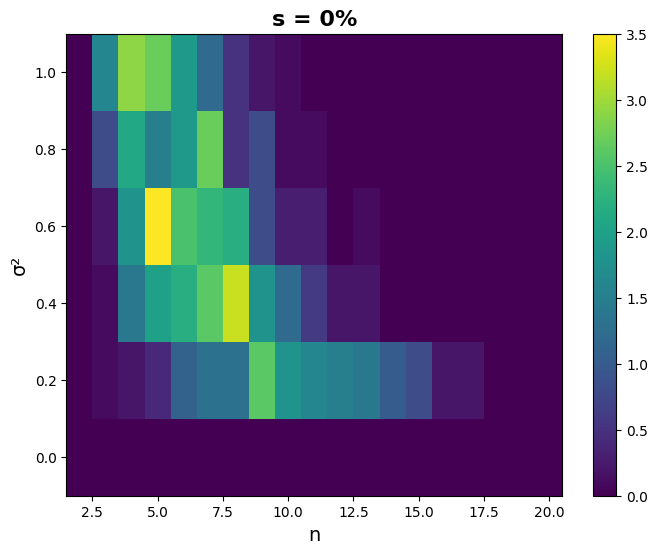

In [29]:
Y, X = np.meshgrid(var, n)
plt.figure(figsize=(8, 6))
colormap = plt.pcolormesh(X, Y, per, cmap='viridis')
plt.colorbar(colormap)
plt.xlabel(r'n', fontsize = 14)
plt.ylabel('\u03C3\u00b2', fontsize = 14)
plt.title('s = 0%', fontsize = 16,  fontweight = 'bold')
plt.show()

- ### Percentage Vertical Volume

(2.0, 20.9)

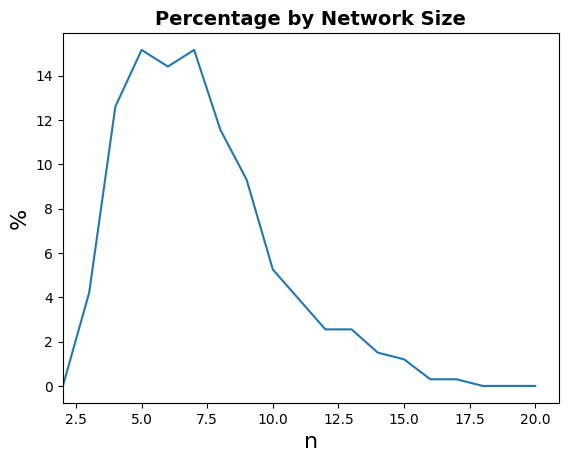

In [33]:
total_percentage = sum(percentage)
share = []
for i in per:
    k = (sum(i)/total_percentage)*100
    share.append(k)
plot = sns.lineplot(x=n, y=share)
plot.set_xlabel('n',fontsize=16)
plot.set_ylabel('%',fontsize=16)
plot.set_title('Percentage by Network Size', fontsize=14, fontweight = 'bold')
plot.set_xlim(n[0])
#plot.axvline(x=5, color='dimgrey', linestyle='--', ymax=10)